In [167]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Literal
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
import operator

In [168]:
generator_llm = ChatOpenAI(model='gpt-4o-mini')
evaluate_llm = ChatOpenAI(model='gpt-4o-mini')
optimizer_llm = ChatOpenAI(model='gpt-4o')

In [169]:
class tweetState(TypedDict):
    topic: str 
    tweet: str 
    evaluation: Literal['approved', 'need_improvements']
    feedback: str 
    iteration: int 
    max_iterations: int

    tweet_history : Annotated[list[str], operator.add]
    feedback_history : Annotated[list[str], operator.add]

In [170]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal['approved', 'need_improvements'] = Field(description="final evaluation")
    feedback: str = Field(..., description="feed_back for the tweet")

In [171]:
structured_evaluation = generator_llm.with_structured_output(TweetEvaluation)

In [172]:
def generate_tweet(state: tweetState):

    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
# - This is version {state['iteration'] + 1}.
""")
    ]

    response = generator_llm.invoke(messages).content

    return {'tweet': response, 'tweet_history': [response]}

In [173]:
def evaluate_tweet(state: tweetState):

    messages = [
        SystemMessage(
            content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."
        ),
        HumanMessage(
            content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?
2. Humor – Did it genuinely make you smile, laugh, or chuckle?
3. Punchiness – Is it short, sharp, and scroll-stopping?
4. Virality Potential – Would people retweet or share it?
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Don't end with generic, throwaway, or deflating lines that weaken the humor

Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"
- feedback: One paragraph explaining the strengths and weaknesses
"""
        )
    ]

    response = structured_evaluation.invoke(messages)

    return {
        "evaluation": response.evaluation,
        "feedback": response.feedback,
        "tweet_feedback": []
    }

In [174]:
def optimize_tweet(state: tweetState):
    messages = [
    SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
    HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration']

    return {'tweet': response, 'iteration': iteration, 'tweet_feedback': [response]}


In [175]:
def check_evaluation(state: tweetState):
    if state['evaluation'] == 'approved' or state['iteration']  >= state['max_iterations']:
        return 'approved'
    else: 
        'need_improvements'

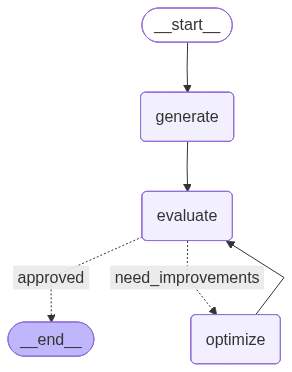

In [176]:
state = StateGraph(tweetState)

state.add_node('generate',generate_tweet)
state.add_node('evaluate', evaluate_tweet)
state.add_node('optimize', optimize_tweet)

state.add_edge(START, 'generate')
state.add_edge('generate','evaluate')
state.add_conditional_edges('evaluate', check_evaluation, {'approved' : END, 'need_improvements' : 'optimize'})
state.add_edge('optimize','evaluate')

workflow = state.compile()
workflow

In [178]:
initial_state = {
    "topic" : "bhjsf",
    "iteration": 1,
    "max_iterations": 5
}
workflow.invoke(initial_state)

{'topic': 'bhjsf',
 'tweet': 'Just found out "bhjsf" is actually the secret code for “Binge Watching Hilarious Jokes, Sort of Fun.” Heads up, Netflix is onto us – there’s now a whole category dedicated to miscommunication and typo-induced chaos. 🤷\u200d♂️📺 #bhjsf #TypoLife',
 'evaluation': 'approved',
 'feedback': 'This tweet demonstrates originality with its unique play on words and the amusing concept of a secret code for binge-watching. The humor is light-hearted and relatable, particularly for those familiar with typos and miscommunication in the digital age. The format is well-structured, staying under the character limit and avoiding traditional joke setups. Its potential for virality is enhanced by the topical reference to Netflix and the use of hashtags, which could resonate well with a wide audience.',
 'iteration': 1,
 'max_iterations': 5,
 'tweet_history': ['Just found out "bhjsf" is actually the secret code for “Binge Watching Hilarious Jokes, Sort of Fun.” Heads up, Netfli